#### Book Recommender 👁️‍🗨️

#### Libraries:

In [1]:
#Database management
import pandas as pd
import numpy as np
import datetime
pd.set_option('display.max_columns', None)

#Plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#Recommender System
import scipy
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

#### The main idea is 💡:
Find similar books inside the same subset (by genre) to the book liked by the user

- Create subsets by genres (as there are over 900 group them first in dictionaries)
- Asking for user imput (what book do you like) if present in df
- Trough KNN recommend a book based on imput
- Adjust KNN model (hyperparameters, n_neighbors etc.)

#### Import the data:

In [2]:
best = pd.read_csv('Data/best_clean.csv')

In [3]:
best.shape

(52478, 29)

#### Create subsets by genres:

In [4]:
import ast
best['genres'] = best['genres'].apply(lambda x: ast.literal_eval(x))

#a set of all unique genres
unique_genres = set()
best['genres'].apply(unique_genres.update)

print(f"Number of unique genres: {len(unique_genres)}")
print(f"Unique genres: {unique_genres}")

Number of unique genres: 982
Unique genres: {'Space Opera', 'Paramedics', 'Western Historical Romance', 'Comic Strips', 'Zambia', 'Nordic Noir', 'Language', 'Gothic Romance', 'Comedian', 'Booze', 'Survival', 'Greece', 'Benin', 'Brewing', 'Reportage', 'Counter Culture', 'Zombies', 'Gothic', 'Nursery Rhymes', 'Bangladesh', 'Planets', 'Malawi', 'Money Management', 'M M Romance', 'Dc Comics', 'Queer Studies', 'Middle Grade', 'Skepticism', 'Horses', 'Paganism', 'Love', 'Japanese Literature', 'Internet', 'Anthologies', 'Hackers', 'Finance', 'Journal', 'Business', 'Dogs', 'Young Adult Historical Fiction', 'Modern Classics', 'The United States Of America', 'Railways', 'Global Warming', 'Australia', 'Jewish', 'Young Adult Romance', 'Webcomic', 'Greek Mythology', 'Historical Mystery', 'Vegan', 'Graphic Novels', 'Central Africa', 'Goth', 'Fat Acceptance', 'Polygamy', 'Religion', 'Nutrition', 'Sewing', 'Rwanda', 'Judaica', 'Astrology', 'Germany', 'Nobel Prize', 'Namibia', 'Action', 'Nature', 'Astr

There are too many combinations of genres so It will better to try to simplyfy.
The first step is to create a list of unique genres and then, the subsets 

In [5]:
genre_subsets = {genre: best[best['genres'].apply(lambda x: genre in x)] for genre in unique_genres}

#number of books per genre
for genre, subset in genre_subsets.items():
    print(f'Genre: {genre}, number of books: {len(subset)}')

Genre: Space Opera, number of books: 543
Genre: Paramedics, number of books: 1
Genre: Western Historical Romance, number of books: 30
Genre: Comic Strips, number of books: 59
Genre: Zambia, number of books: 2
Genre: Nordic Noir, number of books: 44
Genre: Language, number of books: 103
Genre: Gothic Romance, number of books: 22
Genre: Comedian, number of books: 10
Genre: Booze, number of books: 2
Genre: Survival, number of books: 335
Genre: Greece, number of books: 145
Genre: Benin, number of books: 1
Genre: Brewing, number of books: 1
Genre: Reportage, number of books: 8
Genre: Counter Culture, number of books: 13
Genre: Zombies, number of books: 291
Genre: Gothic, number of books: 429
Genre: Nursery Rhymes, number of books: 7
Genre: Bangladesh, number of books: 19
Genre: Planets, number of books: 3
Genre: Malawi, number of books: 1
Genre: Money Management, number of books: 1
Genre: M M Romance, number of books: 544
Genre: Dc Comics, number of books: 141
Genre: Queer Studies, number o

The discrepancy (52478 books in the dataframe vs #52,729 after subset creation) can be attributed to the fact that some books are categorized into multiple genres. 
This leads to overlapping counts when you create subsets based on individual genres. For example, if a book belongs to both "Literary Fiction" and "Romance," it will contribute to the count of books in both genre_subsets['Literary Fiction'] and genre_subsets['Romance'].

👉In json (dictionary-like format) with the help of node.js all the genres have been assigned to more general groups in order to simplify the process

In [6]:
category_groups = {
  "Horror": [
    "Lovecraftian",
    "Cthulhu Mythos",
    "Horror",
    "Ghosts",
    "Demons",
    "Mary Shelley",
    "World Of Darkness",
    "Paranormal Mystery",
    "Noir",
    "Zombies",
    "Gothic Horror",
    "Ghost Stories",
    "Buffy The Vampire Slayer",
    "Gothic Romance",
    "Witches",
    "Cryptids",
    "Splatterpunk",
    "Victor Frankenstein",
    "Dark",
    "Monsters",
    "Halloween",
    "Supernatural"
  ],
  "Erotica": [
    "Erotic Romance",
    "BDSM",
    "Menage",
    "Erotic Paranormal Romance",
    "Erotic Horror",
    "Erotica",
    "Strippers",
    "Omegaverse",
    "Pornography",
    "NSFW",
    "Slash Fiction",
    "Lesbian Fiction",
    "M M M",
    "Yuri",
    "M M F",
    "Polyamorous",
    "M M Mystery",
    "Lesbian Romance",
    "M M Fantasy",
    "M F Romance",
    "New Adult Romance",
    "Gay Erotica",
    "M M Historical Romance",
    "Gay",
    "Boys Love",
    "Queer Lit",
    "Gay Fiction",
    "Mail Order Brides",
    "Lesbian",
    "Clean Romance",
    "M M Paranormal",
    "Intersex",
    "Erotic Historical Romance",
    "Western Romance",
    "Futuristic Romance",
    "Sports Romance",
    "Romantic Suspense"
  ],
  "Literature by Region": [
    "Albanian Literature",
    "Turkish Literature",
    "Spanish Literature",
    "Russian Literature",
    "Japanese Literature",
    "Bulgarian Literature",
    "Finnish Literature",
    "Romanian Literature",
    "Italian Literature",
    "French Revolution",
    "Dutch Literature",
    "Canadian Literature",
    "Swedish Literature",
    "Egyptian Literature",
    "African Literature",
    "Hungarian Literature",
    "Latin American",
    "Ukrainian Literature",
    "African American Literature",
    "Japanese History",
    "German Literature",
    "Roman",
    "Sierra Leone",
    "Morocco",
    "Multicultural Literature",
    "Australia",
    "Belgian",
    "Libya",
    "Senegal",
    "Uganda",
    "Serbian Literature",
    "Ukraine",
    "South Africa",
    "Russian History",
    "Benin",
    "Kazakhstan",
    "Germany",
    "United States",
    "Indian Literature",
    "Irish Literature",
    "Chinese Literature",
    "Denmark",
    "India",
    "Zambia",
    "Scandinavian Literature",
    "Namibia",
    "Kenya",
    "Polish Literature",
    "Greece",
    "Ivory Coast",
    "Asia",
    "Tasmania",
    "Northern Africa",
    "International Literature",
    "Asian Literature",
    "British Literature",
    "European History",
    "European Literature",
    "English Literature",
    "Portuguese Literature",
    "French Literature",
    "Nigeria",
    "Cameroon"
  ],
  "Economy": [
    "Banks",
    "Taxation",
    "Finance",
    "Labor",
    "Frugal",
    "Banking",
    "Money Management",
    "Personal Finance",
    "Economics",
    "Buisness",
    "Business",
    "Political Science",
    "Entrepreneurship",
    "Money"
  ],
  "Classics": [
    "Classics",
    "American Classics",
    "Novella",
    "Literary Criticism",
    "Literary Fiction",
    "Childrens Classics",
    "Classic Literature,",
    "Westerns",
    "Essays",
    "Cinderella",
    "Folklore",
    "20th Century",
    "Historical",
    "Literature",
    "Arthurian",
    "Modern Classics",
    "Romanticism",
    "Canon",
    "17th Century",
    "Medieval History",
    "Epic",
    "Alternate History",
    "10th Century",
    "14th Century",
    "Anglo Saxon",
    "Geoffrey Chaucer",
    "Victor Frankenstein",
    "British Literature",
    "Elizabethan Period",
    "Southern Gothic",
    "Banned Books",
    "16th Century"
  ],
  "Non-Fiction and Others": [
    "Mira",
    "Go",
    "Technical",
    "Audiobook",
    "Apocalyptic",
    "Pop Culture",
    "Geek",
    "Transport",
    "Plays",
    "Government",
    "Read For College",
    "High School",
    "Epic Poetry",
    "Police",
    "Anthologies",
    "Railways",
    "Comedian",
    "Management",
    "M F M",
    "Class",
    "Classical Music",
    "Numerology",
    "Singularity",
    "Urbanism",
    "Teachers",
    "Collections",
    "Utopia",
    "College",
    "2nd Grade",
    "Motorcycling",
    "Silhouette",
    "Pre K",
    "Grad School",
    "Magick",
    "Foster Children",
    "Thelema",
    "Human Resources",
    "International Development",
    "Rus",
    "Booze",
    "Foster Parents",
    "Warriors",
    "Adult",
    "Gastronomy",
    "Food",
    "Hqn",
    "Music",
    "Action",
    "Battle Of Gettysburg",
    "Warcraft",
    "Humanities",
    "Sewing",
    "Pirates",
    "Kids",
    "Moroccan",
    "Wine",
    "Trivia",
    "Internet",
    "Punx",
    "Hackers",
    "Counter Culture",
    "Hip Hop",
    "Esoterica",
    "Near Future",
    "Coming Of Age",
    "Weird West",
    "Rock N Roll",
    "Humor",
    "Puzzles",
    "Fandom",
    "Nerd",
    "Drama",
    "Fables",
    "Holiday",
    "Woodwork",
    "Speculative Fiction",
    "Novels",
    "Research",
    "Journaling",
    "Airships",
    "Helicopters",
    "Lie",
    "Autobiography",
    "Led Zeppelin",
    "Doctor Who",
    "Soccer",
    "Punk",
    "Google",
    "World Of Warcraft",
    "Recreation",
    "Law",
    "Academia",
    "Poetry Plays",
    "Trains",
    "Archaeology",
    "Urban Planning",
    "Survival",
    "School",
    "Musicians",
    "Walking",
    "Beer",
    "International",
    "Poetry",
    "Chapter Books",
    "Mine",
    "Drinking",
    "Adoption",
    "Textbooks",
    "Homeschool",
    "Illness",
    "Reference",
    "Journal",
    "Brewing",
    "Cultural",
    "Food and Drink",
    "Memoir",
    "Fat Acceptance",
    "Activism",
    "Politics",
    "Travelogue",
    "Ethnography",
    "Urban Studies",
    "Cycling",
    "Bicycles",
    "Sex Work",
    "Church History",
    "Prehistory",
    "Quilting",
    "Nursing",
    "Civil War Eastern Theater",
    "World History",
    "Civil War History",
    "History and Politics",
    "Academic",
    "Gender Studies",
    "Guidebook",
    "Reportage",
    "Soviet History",
    "Disability",
    "Disability Studies",
    "Royal Air Force",
    "Professors",
    "Anthropology",
    "Sociology",
    "Anarchism",
    "Back To School",
    "Social Change",
    "Usability",
    "Fashion",
    "Knitting",
    "Horticulture",
    "Electrical Engineering",
    "Academics",
    "Crafts",
    "Brain",
    "Geography",
    "How To",
    "Read For School",
    "Diary",
    "Storytime",
    "Herbs",
    "Lds Non Fiction",
    "Popular Science",
    "Birds",
    "Climbing",
    "Battle Of Britain",
    "American History",
    "Engineering",
    "Jokes",
    "Teaching",
    "Foodie",
    "Books About Books"
  ],
  "Fantasy": [
    "Dark Fantasy",
    "Werewolves",
    "Beauty and The Beast",
    "Fantasy",
    "Science Fiction Fantasy",
    "Dragons",
    "Unicorns",
    "Dragonlance",
    "Fantasy Romance",
    "Fairy Tales",
    "Fractured Fairy Tales",
    "Sword and Planet",
    "Fairy Tale Retellings",
    "Folk Tales",
    "Fantasy Of Manners",
    "Paranormal Urban Fantasy",
    "Speculative Fiction",
    "High Fantasy",
    "Historical Fantasy",
    "Mermaids",
    "Sci Fi Fantasy",
    "Sword and Sorcery",
    "Low Fantasy",
    "Young Adult Paranormal",
    "Princesses",
    "Shonen",
    "Gods",
    "Christian Fantasy",
    "Elves",
    "40k",
    "Prehistoric",
    "Magical Realism",
    "Dungeons and Dragons",
    "Epic Fantasy",
    "Heroic Fantasy",
    "New Weird",
    "Steampunk",
    "Wizards",
    "Fairies",
    "Fae",
    "Weird Fiction",
    "Forgotten Realms",
    "Urban Fantasy"
  ],
  "World": [
    "Zimbabwe",
    "Soviet Union",
    "Maps",
    "Republic Of The Congo",
    "Hungary",
    "Belgium",
    "Sao Tome and Principe",
    "Alexandria",
    "Algeria",
    "Sweden",
    "Bolivia",
    "Italy",
    "Eastern Africa",
    "Liberia",
    "Japan",
    "China",
    "Guinea",
    "Scotland",
    "Tanzania",
    "Poland",
    "Mozambique",
    "Egypt",
    "Guides",
    "Ireland",
    "Somalia",
    "Burundi",
    "Eritrea",
    "Western Africa",
    "Togo",
    "The World",
    "Canada",
    "Holland",
    "Ethiopia",
    "Botswana",
    "Malawi",
    "Rwanda",
    "Israel",
    "Mali",
    "Ghana",
    "Africa",
    "Romania",
    "Sudan",
    "Pakistan",
    "Brasil",
    "Cities",
    "The United States Of America",
    "The Americas"
  ],
  "Nature and Animals": [
    "Horses",
    "Yeti",
    "Peak Oil",
    "Cryptozoology",
    "Conservation",
    "Dogs",
    "Mountaineering",
    "Green",
    "Ornithology",
    "Agriculture",
    "Nature",
    "Environment",
    "Sustainability",
    "Dinosaurs",
    "Plants",
    "Rabbits",
    "Wildlife",
    "Cats",
    "Birds",
    "Animals",
    "Gardening",
    "Horse Racing",
    "Herbs",
    "Wilderness"
  ],
  "Comic and Manga": [
    "Marvel",
    "Superheroes",
    "Media Tie In",
    "Seinen",
    "Graphic Novels Comics",
    "漫画",
    "Comics Bd",
    "Komik",
    "Yaoi",
    "Graphic Novels",
    "Josei",
    "Graphic Novels Comics Manga",
    "Bande Dessinée",
    "Manga Romance",
    "Shojo",
    "Yuri",
    "Batman",
    "Superman",
    "Comic Fantasy",
    "Comic Book",
    "Dc Comics",
    "Shounen Ai",
    "Graphic Novels Manga",
    "Webcomic",
    "Spider Man",
    "Anime",
    "Cartoon",
    "Light Novel",
    "Wonder Woman",
    "Comics Manga",
    "Manhwa",
    "Comix",
    "X Men"
  ],
  "Science": [
    "Biology",
    "Dying Earth",
    "Genetics",
    "Earth Sciences",
    "Game Design",
    "Medicine",
    "Evolution",
    "Technology",
    "Nutrition",
    "Palaeontology",
    "Science Nature",
    "Information Science",
    "Astronomy",
    "Mathematics",
    "Chemistry",
    "Creation Science",
    "Metaphysics",
    "Geology",
    "Human Development",
    "Algebra",
    "Quantum Mechanics",
    "Neuroscience",
    "History Of Science",
    "Algorithms",
    "Geometry",
    "Physics",
    "Traditional Chinese Medicine",
    "Popular Science",
    "Computer Science",
    "Engineering",
    "Pseudoscience"
  ],
  "Religion and Spirituality": [
    "Discipleship",
    "Judaica",
    "Harem",
    "Christianity",
    "Church",
    "Inspirational",
    "Taoism",
    "Muslims",
    "Spiritualism",
    "New Age",
    "Paganism",
    "Theology",
    "Wicca",
    "Satanism",
    "Witchcraft",
    "Christian",
    "Atheism",
    "Spirituality",
    "Judaism",
    "Theosophy",
    "Mormonism",
    "Islamism",
    "New Testament",
    "Christian Living",
    "Baha I",
    "Evangelism",
    "Astrology",
    "Religion",
    "Amish",
    "Greek Mythology",
    "Divination",
    "Intelligent Design",
    "Zen",
    "God",
    "Buddhism",
    "Gods",
    "Biblical",
    "Lds",
    "Belief",
    "Mysticism",
    "Philosophy",
    "Tarot",
    "Ecclesiology",
    "Eastern Philosophy",
    "Lds Fiction",
    "Scripture",
    "Old Testament",
    "Faith",
    "Alchemy",
    "Islam",
    "Hinduism",
    "Muslimah",
    "Christian Non Fiction",
    "Fundamentalism",
    "Christian Historical Fiction",
    "Jewish",
    "Lds Non Fiction",
    "Prayer"
  ],
  "History": [
    "Nazi Party",
    "Presidents",
    "19th Century",
    "Romanovs",
    "Native American History",
    "Latin American History",
    "11th Century",
    "Edwardian",
    "21st Century",
    "Harlequin Historical",
    "History",
    "Ancient History",
    "Tudor Period",
    "Spanish Civil War",
    "Harlequin Presents",
    "Native Americans",
    "Medieval",
    "Roman Britain",
    "Stuart",
    "American Civil War",
    "Ancient",
    "Plantagenet",
    "Microhistory",
    "History Of Medicine",
    "Georgian",
    "Military History",
    "Us Presidents",
    "15th Century",
    "Spanish History",
    "World War I",
    "Historical Mystery",
    "American Revolution",
    "12th Century",
    "Victorian",
    "18th Century",
    "Japanese History",
    "Russian Revolution",
    "20th Century",
    "Historical",
    "Egyptology",
    "Russian History",
    "World War II",
    "Church History",
    "Prehistory",
    "World History",
    "Civil War History",
    "Soviet History",
    "Civil War",
    "Naval Historical Fiction",
    "Naval History",
    "Medieval History",
    "Lenin",
    "10th Century",
    "14th Century",
    "American Revolutionary War",
    "American History",
    "European History",
    "Elizabethan Period",
    "English Civil War",
    "Holocaust"
  ],
  "Fiction": [
    "New Adult",
    "Hard Science Fiction",
    "Young Readers",
    "Realistic Fiction",
    "Biblical Fiction",
    "Star Trek Original Series",
    "Historical Fiction",
    "Time Travel Romance",
    "Science Fiction",
    "Aliens",
    "Animal Fiction",
    "Military Fiction",
    "Post Apocalyptic",
    "Supernatural Romance",
    "Novels",
    "Short Stories",
    "Psychological Thriller",
    "Adventure",
    "Cozy Mystery",
    "Dystopia",
    "Amateur Sleuth",
    "Christian Fiction",
    "Retellings",
    "Murder Mystery",
    "True Crime",
    "Mystery Thriller",
    "Thriller",
    "Climate Change Fiction",
    "Star Trek Deep Space Nine",
    "Contemporary",
    "Boarding School",
    "Star Trek",
    "Teen",
    "Unfinished",
    "Middle Grade",
    "Young Adult Historical Fiction",
    "Star Trek The Next Generation",
    "Star Trek Voyager",
    "Juvenile",
    "Time Travel",
    "Alternate Universe",
    "Young Adult Science Fiction",
    "Star Wars",
    "Fiction",
    "Hard Boiled",
    "Adult Fiction",
    "American Fiction",
    "Modern",
    "Did Not Finish",
    "Short Story Collection",
    "Science Fiction Romance",
    "Young Adult Contemporary",
    "True Story"
  ],
  "Romance": [
    "Love Inspired",
    "Planetary Romance",
    "Young Adult Romance",
    "Contemporary Romance",
    "Western Historical Romance",
    "Christian Romance",
    "M M Sports Romance",
    "Paranormal Romance",
    "Military Romance",
    "M M Contemporary",
    "African American Romance",
    "Swashbuckling",
    "Romantic",
    "Viking Romance",
    "Historical Romance",
    "Mills and Boon",
    "Love Inspired Historical",
    "Loveswept",
    "Georgian Romance",
    "M M Young Adult",
    "Young Adult",
    "M M Romance",
    "Medieval Romance",
    "Love Story",
    "Interracial Romance",
    "",
    "Harlequin Romance",
    "Love Inspired Suspense",
    "Lesbian Romance",
    "M F Romance",
    "New Adult Romance",
    "Regency Romance",
    "Harlequin Heartwarming",
    "Category Romance",
    "Traditional Regency",
    "Harlequin Blaze",
    "Harlequin Nocturne",
    "Harlequin",
    "Regency",
    "Western Romance",
    "Futuristic Romance",
    "Sports Romance",
    "Romantic Suspense",
    "Harlequin Desire"
  ],
  "Computer Science": [
    "Programming",
    "Coding",
    "Virtual Reality",
    "Mmorpg",
    "Computers",
    "Website Design",
    "Artificial Intelligence",
    "Software",
    "Algorithms",
    "Computer Science"
  ],
  "Psychology": [
    "Counselling",
    "Relationships",
    "Mental Illness",
    "Psychology",
    "Psychiatry",
    "Growth Mindset",
    "Emotion",
    "Gender and Sexuality",
    "Parenting",
    "Personal Development",
    "Mental Health",
    "Asexual"
  ],
  "Languages": [
    "Turkish",
    "Danish",
    "Language",
    "Linguistics"
  ],
  "Arts and Creativity": [
    "Design",
    "Colouring Books",
    "Gothic",
    "Street Art",
    "Graffiti",
    "Photography",
    "Architecture",
    "Visual Art",
    "Pre Raphaelite",
    "Picture Books",
    "Museums",
    "Sequential Art",
    "Art Design",
    "Woodwork",
    "Art and Photography",
    "Musicals",
    "Art History",
    "Jewellery",
    "Games",
    "Quilting",
    "Gardening",
    "Film",
    "Theatre",
    "Jazz",
    "Comedy",
    "Art",
    "Writing",
    "Crafts",
    "Drawing",
    "Surreal",
    "Comics Manga",
    "Comix"
  ],
  "Mystery": [
    "Mystery",
    "Suspense",
    "Occult",
    "Cozy Mystery",
    "Historical Mystery",
    "Mystery Thriller",
    "Murder Mystery",
    "Paranormal",
    "Spy Thriller",
    "Legal Thriller",
    "Whodunit",
    "Noir",
    "Ghost Stories",
    "Golden Age Mystery",
    "Detective",
    "Hard Boiled",
    "Deception"
  ],
  "Health": [
    "Emergency Services",
    "Fitness",
    "Alternative Medicine",
    "Vaccines",
    "Disease",
    "Health",
    "Food Preservation",
    "Paramedics",
    "Doctors",
    "Health Care",
    "Vegetarian",
    "Self Help",
    "Illness",
    "Vegan",
    "Naturopathy",
    "Diets",
    "Medical"
  ],
  "Crime": [
    "Crime",
    "Nordic Noir",
    "Pulp",
    "True Crime",
    "Conspiracy Theories",
    "Whodunit",
    "Noir",
    "Detective"
  ],
  "Sports": [
    "Basketball",
    "Mixed Martial Arts",
    "Martial Arts",
    "Racing",
    "Cycling",
    "Football",
    "Fighters",
    "Hockey",
    "Climbing"
  ],
  "Culture and Society": [
    "Social Justice",
    "Gay For You",
    "Plus Size",
    "Womens",
    "Adolescence",
    "Polygamy",
    "African American",
    "Road Trip",
    "Race",
    "Cultural Studies",
    "Communication",
    "Prostitution",
    "Fire Services",
    "LGBT",
    "Biography Memoir",
    "International Relations",
    "Poverty",
    "Food Writing",
    "Global Warming",
    "Bisexual",
    "Feminism",
    "Womens Studies",
    "Sexuality",
    "Alcohol",
    "Americana",
    "Far Right",
    "Leadership",
    "Oral History",
    "Marriage",
    "New York",
    "Social Media",
    "Outdoors",
    "Field Guides",
    "Book Club",
    "Holiday",
    "Queer",
    "Polyamory",
    "Gender",
    "Anti Intellectualism",
    "Slice Of Life",
    "Family",
    "Social Movements",
    "Social Work",
    "Multicultural Literature",
    "Adoption",
    "Cultural",
    "Society",
    "Fat Acceptance",
    "Southern",
    "Activism",
    "Sex Work",
    "Gender Studies",
    "Queer Lit",
    "Anarchism",
    "Social Science",
    "Anti Racist",
    "Female Authors",
    "Fat",
    "Transgender",
    "Fostering",
    "Social Issues"
  ],
  "Games": [
    "Video Games",
    "Gamebooks",
    "Choose Your Own Adventure"
  ],
  "Science Fiction": [
    "Military Science Fiction",
    "Cyberpunk",
    "Space Opera",
    "Space"
  ]
}

In [7]:
#there may be missing categories in the dictionary

After mapping, If a book's genres match multiple categories (for example, if a book has both 'Fantasy' and 'Romance' genres), the function will still only return the first matching category it finds.
The function will return the first category where it finds a match between genres and group_genres.
This means if a book has genres that match multiple categories, it will choose the first category that appears in category_groups where there is a match. 

In [8]:
#Function to map genres to categories
def map_genres_to_category(genres, category_groups):
    for category, group_genres in category_groups.items():
        if any(genre in group_genres for genre in genres):
            return category
    return None

In [9]:
#Mapping genres to categories
best['category'] = best['genres'].apply(lambda x: map_genres_to_category(x, category_groups))

### Preprocessing data

After many failed attempts that later will be included I realized there was a much needed cleaning process

In [10]:
#erase genres column
best.drop('genres', axis=1, inplace=True)

In [11]:
#rename column category to genre
best.rename(columns={'category': 'genre'}, inplace=True)

In [12]:
best['genre'].isnull().sum()

5155

In [13]:
best['genre'].value_counts()

genre
Non-Fiction and Others       12009
Classics                      8931
Literature by Region          8116
Horror                        6902
Erotica                       3105
Fantasy                       3003
Fiction                       1718
Religion and Spirituality     1164
Economy                        939
Comic and Manga                255
History                        238
Nature and Animals             188
Romance                        159
World                          123
Science                        105
Arts and Creativity            101
Psychology                      80
Mystery                         75
Culture and Society             44
Health                          33
Sports                          13
Languages                        8
Computer Science                 6
Crime                            5
Science Fiction                  3
Name: count, dtype: int64

In [14]:
best['genre'].fillna(best['genre'].mode()[0], inplace=True)

C:\Users\Elsa\AppData\Local\Temp\ipykernel_6492\748924298.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  best['genre'].fillna(best['genre'].mode()[0], inplace=True)


In [15]:
best['genre'].isnull().sum()

0

In [16]:
#unique genres
unique_genres = best['genre'].unique()
#subset of genres 
genre_subsets = {genre: best[best['genre'] == genre] for genre in unique_genres}

In [17]:
#number of books in each subset
for genre, subset in genre_subsets.items():
    print(f"{genre}: {len(subset)}")

Non-Fiction and Others: 17164
Classics: 8931
Horror: 6902
Literature by Region: 8116
Fantasy: 3003
Economy: 939
Erotica: 3105
Fiction: 1718
Religion and Spirituality: 1164
Psychology: 80
Comic and Manga: 255
Culture and Society: 44
World: 123
Science: 105
Arts and Creativity: 101
History: 238
Nature and Animals: 188
Romance: 159
Mystery: 75
Sports: 13
Computer Science: 6
Health: 33
Crime: 5
Languages: 8
Science Fiction: 3


In [18]:
# Check for duplicates based on isbn (unique code)
duplicate_isbn = best[best.duplicated(subset=['isbn'], keep=False)]
print(duplicate_isbn)

                                                  bookid  \
2                             2657.To_Kill_a_Mockingbird   
3                               1885.Pride_and_Prejudice   
7                         11127.The_Chronicles_of_Narnia   
10                       11870085-the-fault-in-our-stars   
11           386162.The_Hitchhiker_s_Guide_to_the_Galaxy   
...                                                  ...   
52407  2823038-forever-young-forever-free-forever-you...   
52416                               23014216-when-i-fall   
52417                                    26158233-aideen   
52420                            25313988-spelarens-sten   
52474                                   11836711-anasazi   

                                                   title  \
2                                  To Kill a Mockingbird   
3                                    Pride and Prejudice   
7                               The Chronicles of Narnia   
10                                The F

In [19]:
#based on title
duplicate_title = best[best.duplicated(subset=['title'], keep=False)]
print(duplicate_title)

                       bookid          title                     series  \
4              41865.Twilight       Twilight       The Twilight Saga #1   
6          170448.Animal_Farm    Animal Farm       Not part of a series   
18            10210.Jane_Eyre      Jane Eyre       Not part of a series   
24     18144590-the-alchemist  The Alchemist       Not part of a series   
28       256683.City_of_Bones  City of Bones  The Mortal Instruments #1   
...                       ...            ...                        ...   
52471      12464361-elemental      Elemental          Soul Guardians #2   
52472   12395883-unbelievable   Unbelievable               Port Fare #2   
52473      11492014-fractured      Fractured                 Fateful #2   
52475         10815662-marked         Marked          Soul Guardians #1   
52476    11330278-wayward-son    Wayward Son       Not part of a series   

                                                  author  rating  \
4                              

It's possible for different books (different isbn) to have the same title. For example, books with different editions or translations may share the same title but have unique ISBNs.
Conversely, books with the same ISBN might have different titles (e.g., different editions with slightly modified titles).

In [20]:
duplicate_rows = best[best.duplicated(keep=False)]
print(duplicate_rows)

                                                bookid  \
37377                         8794263-promises-to-keep   
37378                                    1909590.Click   
37379               23394408-die-unendlichkeit-schl-ft   
37380                               7544945-death-note   
37381                                25886017-m-scaras   
...                                                ...   
37480                              26845691-beatlebone   
37481              22916606-gli-enigmi-dei-vedovi-neri   
37482                                       13571757-1   
37483  1481056.Gifts_and_Ministries_of_the_Holy_Spirit   
37484                      27074409-deadly-class-vol-1   

                                         title  \
37377                         Promises to Keep   
37378                                    Click   
37379                Die Unendlichkeit schläft   
37380        Death Note: Black Edition, Vol. 2   
37381                                 Máscaras   
...

In [21]:
# Drop duplicates based on all columns
best_no_duplicates = best.drop_duplicates()

print("Original DataFrame shape:", best.shape)
print("DataFrame shape after dropping duplicates:", best_no_duplicates.shape)

Original DataFrame shape: (52478, 29)
DataFrame shape after dropping duplicates: (52428, 29)


### First attempts of KNN model recommender

In [22]:
'''#Selecting the features to be used in the model
features = ['rating', 'pages','likedpercent','category','price','author','bbescore']
df_features = best[features]

#convert categorical to numerical (one hot encoding)
df_features = pd.get_dummies(df_features, columns=['category','author'])'''

"#Selecting the features to be used in the model\nfeatures = ['rating', 'pages','likedpercent','category','price','author','bbescore']\ndf_features = best[features]\n\n#convert categorical to numerical (one hot encoding)\ndf_features = pd.get_dummies(df_features, columns=['category','author'])"

In [23]:
'''numerical_features = ['rating', 'pages','likedpercent','price','bbescore']

#Standardization
scaler = StandardScaler()
df_features[numerical_features] = scaler.fit_transform(df_features[numerical_features])'''

"numerical_features = ['rating', 'pages','likedpercent','price','bbescore']\n\n#Standardization\nscaler = StandardScaler()\ndf_features[numerical_features] = scaler.fit_transform(df_features[numerical_features])"

In [24]:
'''#Let's train the model and after and ajdust and optimize the parameters later
knn = NearestNeighbors(n_neighbors=5, algorithm='auto').fit(df_features)'''

"#Let's train the model and after and ajdust and optimize the parameters later\nknn = NearestNeighbors(n_neighbors=5, algorithm='auto').fit(df_features)"

I get the error MemoryError error indicates that your system does not have enough RAM to handle the size of the array you are trying to create. So let's try a PCA (dimensionality reduction technique): to reduce the number of features.

In [25]:
'''from sklearn.decomposition import PCA
pca = PCA(n_components=50)
df_features_reduced = pca.fit_transform(df_features)'''

'from sklearn.decomposition import PCA\npca = PCA(n_components=50)\ndf_features_reduced = pca.fit_transform(df_features)'

Again MemoryError: Unable to allocate 11.0 GiB for an array with shape (28227, 52478) and data type float64

In [26]:
'''#Let's try reducing features
#Selecting the features to be used in the model
features = ['rating','likedpercent','category','price','author']
df_features = best[features]

#convert categorical to numerical (one hot encoding)
df_features = pd.get_dummies(df_features, columns=['category','author'])'''

"#Let's try reducing features\n#Selecting the features to be used in the model\nfeatures = ['rating','likedpercent','category','price','author']\ndf_features = best[features]\n\n#convert categorical to numerical (one hot encoding)\ndf_features = pd.get_dummies(df_features, columns=['category','author'])"

In [27]:
'''numerical_features = ['rating','likedpercent','price']

#Standardization
scaler = StandardScaler()
df_features[numerical_features] = scaler.fit_transform(df_features[numerical_features])'''

"numerical_features = ['rating','likedpercent','price']\n\n#Standardization\nscaler = StandardScaler()\ndf_features[numerical_features] = scaler.fit_transform(df_features[numerical_features])"

In [28]:
'''knn = NearestNeighbors(n_neighbors=5, algorithm='auto').fit(df_features)'''

"knn = NearestNeighbors(n_neighbors=5, algorithm='auto').fit(df_features)"

Same error. Let's try another approach
Preprocessing pipeline: to handle textual and numerical features efficiently. Then I'll apply KNN on each genre subset.

In [29]:
'''#Make sure there are no missing values
best['description'] = best['description'].fillna('No description available')

#Create subsets for each category
genre_subsets = {genre: best[best['category'] == genre] for genre in best['category'].unique()}'''

"#Make sure there are no missing values\nbest['description'] = best['description'].fillna('No description available')\n\n#Create subsets for each category\ngenre_subsets = {genre: best[best['category'] == genre] for genre in best['category'].unique()}"

Definition of the Preprocessing Pipeline:
TfidfVectorizer for the description column.
Imputation and normalization for numerical characteristics (rating, pages, numratings, likedpercent, price).

Then, transform each genre subset using the defined pipeline:

In [30]:
'''#Pre-process subsets
processed_subsets = {genre: preprocessor.fit_transform(subset) for genre, subset in genre_subsets.items()}'''

'#Pre-process subsets\nprocessed_subsets = {genre: preprocessor.fit_transform(subset) for genre, subset in genre_subsets.items()}'

In [31]:
'''#Define knn models for each genre subset
#knn_models = {genre: NearestNeighbors(n_neighbors=5, algorithm='auto').fit(features) for genre, features in processed_subsets.items()}'''

"#Define knn models for each genre subset\n#knn_models = {genre: NearestNeighbors(n_neighbors=5, algorithm='auto').fit(features) for genre, features in processed_subsets.items()}"

In [32]:
'''#define vectorizer
vectorizer = TfidfVectorizer(stop_words='english')
vectorizer.fit(best['description'])'''

"#define vectorizer\nvectorizer = TfidfVectorizer(stop_words='english')\nvectorizer.fit(best['description'])"

In [33]:
'''#Crear un índice KNN para cada subset de género
knn_models = {genre: NearestNeighbors(n_neighbors=5, algorithm='auto').fit(features)
              for genre, (features, _) in processed_subsets.items()}'''

"#Crear un índice KNN para cada subset de género\nknn_models = {genre: NearestNeighbors(n_neighbors=5, algorithm='auto').fit(features)\n              for genre, (features, _) in processed_subsets.items()}"

I tried many variations of this pipeline approach but got all kinds of errors

Almost everytime I got this problem:
A mismatch between the number of features in the input data (X) and what the NearestNeighbors model expected.
Because the input data (X) provided to the NearestNeighbors model does not match the dimensions that the model was trained on.

After some debugging statments, they indicated that each genre subset (processed_features) had a different number of features, which aligns with the error message. 

#### Final approach:

In [34]:
#Fill missing values

best['description'] = best['description'].fillna('No description available')
#best['genre'] = best['genre'].fillna('Unknown') (already done)
best['rating'] = best['rating'].fillna(best['rating'].mean())
best['pages'] = best['pages'].fillna(best['pages'].mean())
best['numratings'] = best['numratings'].fillna(best['numratings'].mean())
best['likedpercent'] = best['likedpercent'].fillna(best['likedpercent'].mean())
best['price'] = best['price'].fillna(best['price'].mean())

In [35]:
#Create subsets by genre (already done some cells above)
'''genre_subsets = {genre: best[best['genre'] == genre] for genre in best['genre'].unique()}'''

"genre_subsets = {genre: best[best['genre'] == genre] for genre in best['genre'].unique()}"

In this part:
A ``TfidfVectorizer`` is created to convert text descriptions (from column 'description') into numerical vectors.

A ``ColumnTransformer`` is defined that applies:
``TfidfVectorizer`` to the 'description' column.
A Pipeline that first imputes missing values ​​with ``SimpleImputer`` and then scales the numeric data with ``StandardScaler`` to the numeric columns.
The preprocessor wraps around the entire dataframe to ensure that all transformations are consistent.(This is extremely important)

In [36]:
#Define vectorizer 
vectorizer = TfidfVectorizer(stop_words='english')

#Define pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('desc', vectorizer, 'description'),
        ('num', Pipeline(steps=[
            ('impute', SimpleImputer(strategy='mean')),
            ('scale', StandardScaler())
        ]), ['rating', 'pages', 'numratings', 'likedpercent', 'price'])
    ])

#Fit preprocessor
preprocessor.fit(best)

ColumnTransformer(transformers=[('desc', TfidfVectorizer(stop_words='english'),
                                 'description'),
                                ('num',
                                 Pipeline(steps=[('impute', SimpleImputer()),
                                                 ('scale', StandardScaler())]),
                                 ['rating', 'pages', 'numratings',
                                  'likedpercent', 'price'])])

Next:
The preprocessor is applied to each genre subset, transforming the data into numerical characteristics.

The transformed data is stored along with the original subset in processed_subsets.
A KNN model is fit for each gender subset using the transformed characteristics.

In [37]:
#Apply the preprocessor to each subset
processed_subsets = {}
for genre, subset in genre_subsets.items():
    processed_features = preprocessor.transform(subset)
    processed_subsets[genre] = (processed_features, subset)

#Create a dictionary of knn models
knn_models = {genre: NearestNeighbors(n_neighbors=5, algorithm='auto').fit(features)
              for genre, (features, _) in processed_subsets.items()}

THE FUNCTION:
- It searches for books whose title contains the first letters provided by the user (with an input)
- If it finds a match (the match is in de dataset), it prompts the user to confirm the correct book.
- If the book belongs to a genre with a KNN model and preprocessed data, it transforms the book features and uses KNN to find similar books.
- Finally Returns a list of recommended titles based on the closest books.

In [38]:
#I may add a feature where it opens up the url with the book cover

In [39]:
#Function to recommend books!

def recommend_books(book_title, df, knn_models, processed_subsets, preprocessor):
    #Find matching books
    matching_books = df[df['title'].str.contains(book_title, case=False, na=False)]
    
    if matching_books.empty:
        return "Lo siento, este libro no lo tenemos. Prueba otro."

    #Confirm book with user
    for i, row in matching_books.iterrows():
        user_confirmation = input(f"¿Es '{row['title']}' el libro que te gusta? (escribe 'yes' o 'si' para confirmar): ")
        if user_confirmation.lower() in ['yes', 'si']:
            book = row
            genre = book['genre']
            
            #verify if the genre of the book has a KNN model and a preprocessor
            if genre not in knn_models or genre not in processed_subsets:
                return f"No se pudo procesar el género {genre}."

            processed_features, subset = processed_subsets[genre]
            
            #Preprocess book features using the corresponding tuned preprocessor
            book_features = preprocessor.transform(pd.DataFrame([book]))
            
            #Find similar books using KNN and genre
            knn_model = knn_models[genre]
            distances, indices = knn_model.kneighbors(book_features, n_neighbors=5)
            
            #Get the titles
            recommended_books = subset.iloc[indices[0]]['title'].tolist()
            #books_url= subset.iloc[indices[0]]['url'].tolist()
            return recommended_books #,books_url
    
    return "No se confirmó ningún libro. Por favor, inténtalo de nuevo."


Finally:
Asks the user for the first letters of the title of the book they like.
Call recommend_books with the given book title.
Prints recommendations based on the specified book.

In [40]:
#Ask for user input
user_book = input("Introduce las primeras letras del título del libro que te gusta: ")
recommendations = recommend_books(user_book, best, knn_models, processed_subsets, preprocessor)
print(f"Recomendaciones para '{user_book}': {recommendations}")
#for i in urls:
#    print(open.image(i)) urllib

Recomendaciones para 'twilight': ['Twilight', 'City of Bones', 'New Moon', 'Eclipse', 'Breaking Dawn']


In [41]:
#adding the IMAGE feature with Ipython.display

In [42]:
from IPython.display import Image, display

def recommend_books(book_title, df, knn_models, processed_subsets, preprocessor):
    # Find matching books
    matching_books = df[df['title'].str.contains(book_title, case=False, na=False)]
    
    if matching_books.empty:
        return "Lo siento, este libro no lo tenemos. Prueba otro."

    # Confirm book with user
    for i, row in matching_books.iterrows():
        user_confirmation = input(f"¿Es '{row['title']}' el libro que te gusta? (escribe 'yes' o 'si' para confirmar): ")
        if user_confirmation.lower() in ['yes', 'si']:
            book = row
            genre = book['genre']
            
            # Verify if the genre of the book has a KNN model and a preprocessor
            if genre not in knn_models or genre not in processed_subsets:
                return f"No se pudo procesar el género {genre}."

            processed_features, subset = processed_subsets[genre]
            
            # Preprocess book features using the corresponding tuned preprocessor
            book_features = preprocessor.transform(pd.DataFrame([book]))
            
            # Find similar books using KNN and genre
            knn_model = knn_models[genre]
            distances, indices = knn_model.kneighbors(book_features, n_neighbors=5)
            
            # Get the titles and URLs of the recommended books
            recommended_books = subset.iloc[indices[0]][['title', 'coverimg']].to_dict('records')
            
            # Display recommended books and their cover images
            for book in recommended_books:
                print(f"Recomendado: {book['title']}")
                display(Image(book['coverimg'],width=300, height=600))
            
            return recommended_books
    
    return "No se confirmó ningún libro. Por favor, inténtalo de nuevo."



Tu busqueda ha sido: 'pride' y sus recomendaciones:
Recomendado: Pride and Prejudice


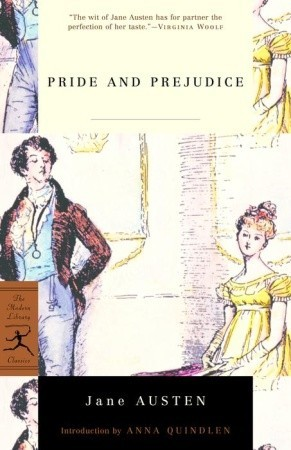

Recomendado: The Hobbit, or There and Back Again


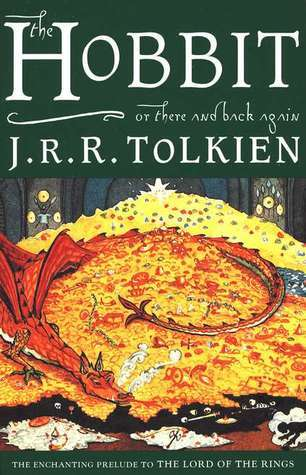

Recomendado: 1984


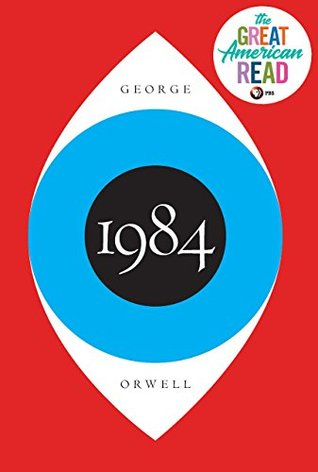

Recomendado: Harry Potter and the Prisoner of Azkaban


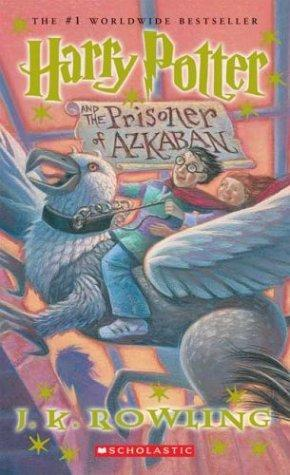

Recomendado: The Diary of a Young Girl


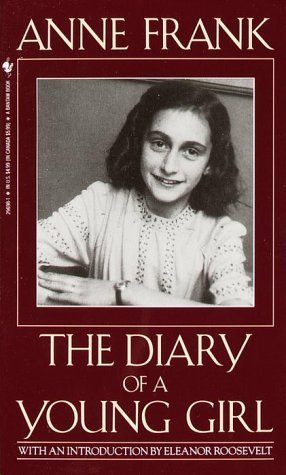

In [43]:
# Ask for user input
user_book = input("Introduce las primeras letras del título del libro que te gusta: ")
print(f"Tu busqueda ha sido: '{user_book}' y sus recomendaciones:")
recommendations = recommend_books(user_book, best, knn_models, processed_subsets, preprocessor)

In [44]:
from IPython.display import Image, display


def recommend_books(book_title, df, knn_models, processed_subsets, preprocessor):
    # Find matching books
    matching_books = df[df['title'].str.contains(book_title, case=False, na=False)]
    
    if matching_books.empty:
        return "Lo siento, este libro no lo tenemos. Prueba otro."

    # Confirm book with user
    for i, row in matching_books.iterrows():
        user_confirmation = input(f"¿Es '{row['title']}' el libro que te gusta? (escribe 'yes' o 'si' para confirmar): ")
        if user_confirmation.lower() in ['yes', 'si']:
            book = row
            genre = book['genre']
            
            # Verify if the genre of the book has a KNN model and a preprocessor
            if genre not in knn_models or genre not in processed_subsets:
                return f"No se pudo procesar el género {genre}."

            processed_features, subset = processed_subsets[genre]
            
            # Preprocess book features using the corresponding tuned preprocessor
            book_features = preprocessor.transform(pd.DataFrame([book]))
            
            # Find similar books using KNN and genre
            knn_model = knn_models[genre]
            distances, indices = knn_model.kneighbors(book_features, n_neighbors=5)
            
            # Get the titles and URLs of the recommended books
            recommended_books = subset.iloc[indices[0]][['title', 'coverimg']].to_dict('records')
            
            # Display the first book as the confirmed one and others as recommended
            first_book = True
            for book in recommended_books:
                if first_book:
                    print(f"Este es tu libro: {book['title']}")
                    first_book = False
                else:
                    print(f"Te recomiendo {book['title']}")
                display(Image(book['coverimg'], width=300, height=600))
            
            return recommended_books
    
    return "No se confirmó ningún libro. Por favor, inténtalo de nuevo."


Tu busqueda ha sido: 'hobbit' y...
Este es tu libro: J.R.R. Tolkien 4-Book Boxed Set: The Hobbit and The Lord of the Rings


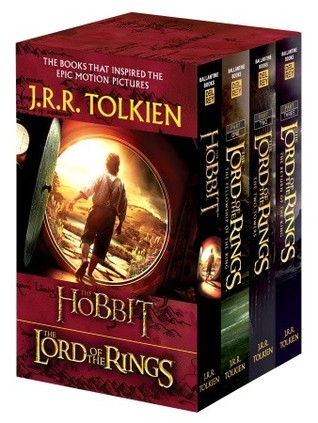

Te recomiendo The Complete Sherlock Holmes


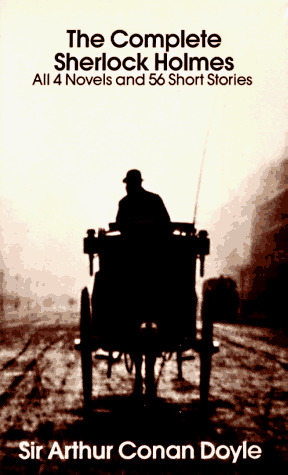

Te recomiendo The Harry Potter Collection 1-4


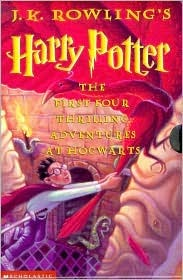

Te recomiendo El conde de Montecristo / Los tres mosqueteros


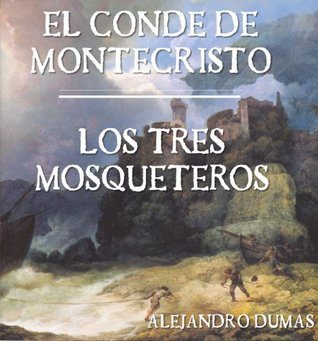

Te recomiendo The Complete Works: The Revised Oxford Translation, Vol. 1


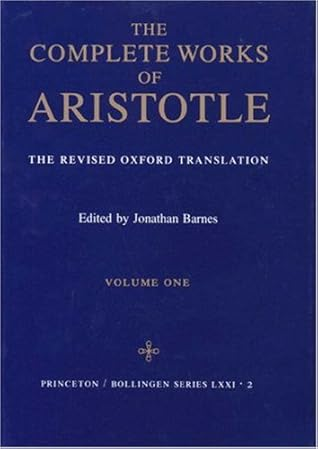

In [45]:
# Ask for user input
user_book = input("Introduce las primeras letras del título del libro que te gusta: ")
print(f"Tu busqueda ha sido: '{user_book}' y...")
recommendations = recommend_books(user_book, best, knn_models, processed_subsets, preprocessor)

Saving the preprocessor and KNN models so I will be able to use it in Streamlit

In [46]:
import joblib

#Save the preprocessor
joblib.dump(preprocessor, 'preprocessor.pkl')

#Save the KNN models dictionary
joblib.dump(knn_models, 'knn_models.pkl')

#Save the processed subsets for later use
joblib.dump(processed_subsets, 'processed_subsets.pkl')

#Save the best DataFrame (if needed)
best.to_pickle('best_df.pkl')
